# About

This notebook is focused on retrieving the XML data via King County's API, cleaning it into Pandas Data Frame format, and formatting the values and data types.

#### Notebook contents<a id="top"></a>

* <a href="#xml">Get the raw XML</a>
* <a href="#parsexml">Element tree structure</a>
* <a href="#toulouse">A business with lots of violations: Toulouse Petit</a>
* <a href="#dataframe">Reformatting XML into a Pandas Data Frame</a>
* <a href="#clean">Data cleaning</a>
* <a href="#plot">Visual inspection</a>

In [136]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
%matplotlib inline

## <font color="red">Get the raw XML</font><a id="xml"></id>
[<a href="#top">back to top</a>]

In [3]:
def get_xml(**kwargs):
    ''' Returns root XML tree structure using King County's API
    
        Kwargs
        ======
        Business_Name - string
        Business_Address - string
        Zip_Code - string
        Inspection_Start - string with valid date in format MM/DD/YYYY
        Inspection_End - string with valid date in format MM/DD/YYYY
        Violation_Points - string with Integer <= 999
        Violation_Red_Points - string with Integer <=999
        City - string
        
        Example
        =======
        Returns inspection data in zip code 98101 since 1/1/2016
        >>> get_data(Zip_Code='98101', Inspection_Start=1/1/2016)
        
        Notes
        =====
        The API appears to break using parameter Inspection_Closed_Business
    '''
    if kwargs == None:
        print('Oh no! You forgot to select at least one parameter')
        return
        
    else:
        url = 'http://info.kingcounty.gov/health/ehs/foodsafety/inspections/XmlRest.aspx?'
        for key in kwargs:
            s = '='.join([key, kwargs[key]])
            url = '&'.join([url, s])
    # retrieve data
    response = requests.get(url)
    root = ET.fromstring(response.content)
    # Remove the King County data disclaimer
    disclaimer_element = root.find('Disclaimer')
    root.remove(disclaimer_element)
    return root

Toulouse Petit is a popular restaurant in Seattle that recently got closed by the health department for failing inspections. Let's pull 2016 inspections which would include the Toulouse Petit violations to verify the structure of the data.

In [4]:
# get some data that would select Toulouse Petit
root = get_xml(Zip_Code='98109', Inspection_Start='1/1/2016', Inspection_End='12/31/2016')

## <font color="red">Element tree structure</font><a id="parsexml"></id>
[<a href="#top">back to top</a>]

Let's see what kind of tags are available to query from the data for each business

In [5]:
root[0].getchildren()

[<Element 'Name' at 0x10aa7a728>,
 <Element 'Program_Identifier' at 0x10aa7a5e8>,
 <Element 'Description' at 0x10aa7a458>,
 <Element 'Address' at 0x10aa7a4a8>,
 <Element 'City' at 0x10aa7a3b8>,
 <Element 'Zip_Code' at 0x10aa7ae08>,
 <Element 'Phone' at 0x10aa7aea8>,
 <Element 'Longitude' at 0x10aac81d8>,
 <Element 'Latitude' at 0x10aac8188>,
 <Element 'Inspection' at 0x10aac8228>,
 <Element 'Inspection' at 0x10aac8688>]

Do any of these elements have children?

In [6]:
for child in root[0].getchildren():
    print(child.tag, child.getchildren())

Name []
Program_Identifier []
Description []
Address []
City []
Zip_Code []
Phone []
Longitude []
Latitude []
Inspection [<Element 'Inspection_Date' at 0x10aac8278>, <Element 'Inspection_Business_Name' at 0x10aac8318>, <Element 'Inspection_Type' at 0x10aac8368>, <Element 'Inspection_Score' at 0x10aac8408>, <Element 'Inspection_Result' at 0x10aac8458>, <Element 'Inspection_Closed_Business' at 0x10aac84f8>, <Element 'Violation' at 0x10aac8548>]
Inspection [<Element 'Inspection_Date' at 0x10aac86d8>, <Element 'Inspection_Business_Name' at 0x10aac8728>, <Element 'Inspection_Type' at 0x10aac8778>, <Element 'Inspection_Score' at 0x10aac8818>, <Element 'Inspection_Result' at 0x10aac8868>, <Element 'Inspection_Closed_Business' at 0x10aac88b8>, <Element 'Violation' at 0x10aac8908>, <Element 'Violation' at 0x10aac8a48>]


The 'Inspection' element is not terminal. Are any of its elements non-terminal as well?

In [13]:
# the last inspection for the first business in root
root[0][-1].getchildren()

[<Element 'Inspection_Date' at 0x10cedcae8>,
 <Element 'Inspection_Business_Name' at 0x10cedcb38>,
 <Element 'Inspection_Type' at 0x10cedcb88>,
 <Element 'Inspection_Score' at 0x10cedcc28>,
 <Element 'Inspection_Result' at 0x10cedcc78>,
 <Element 'Inspection_Closed_Business' at 0x10cedccc8>,
 <Element 'Violation' at 0x10cedcd18>,
 <Element 'Violation' at 0x10cedce58>]

In [14]:
# So the value for the Inspection_Date would be... 
root[0][-1][0].text

'02/24/2016'

In the raw XML (downloaded or viewing in the browser), it looks like each Violation has child elements as well.

In [19]:
# elements for the first business, last inspection, last violation of that inspection
root[0][-1][-1].getchildren()

[<Element 'Violation_Type' at 0x10cedcea8>,
 <Element 'Violation_Descr' at 0x10cedcef8>,
 <Element 'Violation_Points' at 0x10cedcf48>]

In [20]:
root[0][-1][-1][1].text # Violation_Descr for above

'4200 - Food-contact surfaces maintained, clean, sanitized'

## <font color="red">A business with lots of violations: Toulouse Petit</font><a id="toulouse"></id>
[<a href="#top">back to top</a>]

In [ ]:
business = root[339] # toulouse petit node

In [8]:
def get_attribute(node, attribute):
    if node.find(attribute) is not None:
        return node.find(attribute).text
    else:
        return None

In [633]:
for inspection in business.findall('Inspection'):
        for violation in inspection.findall('Violation'):
            print(get_attribute(business, 'Name'), 
                  get_attribute(inspection, 'Inspection_Date'), 
                  get_attribute(violation, 'Violation_Type'))

TOULOUSE PETIT KITCHEN & LOUNGE 09/27/2016 None
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 BLUE
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 BLUE
TOULOUSE PETIT KITCHEN & LOUNGE 09/22/2016 BLUE
TOULOUSE PETIT KITCHEN & LOUNGE 06/20/2016 None
TOULOUSE PETIT KITCHEN & LOUNGE 01/26/2016 RED
TOULOUSE PETIT KITCHEN & LOUNGE 01/26/2016 BLUE
TOULOUSE PETIT KITCHEN & LOUNGE 01/26/2016 BLUE


Comparing with the raw XML, it looks like all the inspections and violations are being retrieved correctly for Toulouse Petit. 

Now for multiple businesses...

## <font color="red">Reformatting the XML into a Pandas Data Frame</font><a id="dataframe"></id>
[<a href="#top">back to top</a>]

Finally time to get rid of this unsavory XML format once and for all!

Let's try the above for multiple businesses...

In [634]:
businesses = root[0:5]

for b in range(0, len(businesses)):
    business = businesses[b]
    if business.find('Inspection'): # not every business has inspections in the data, oddly
        for inspection in business.findall('Inspection'):
            
            if inspection.find('Violation'): # not every inspection has violations...
                for violation in inspection.findall('Violation'):
                    print(get_attribute(business, 'Name'), 
                          get_attribute(inspection, 'Inspection_Date'), 
                          get_attribute(violation, 'Violation_Type'))
            else:
                print(get_attribute(business, 'Name'), 
                      get_attribute(inspection, 'Inspection_Date'))

10 MERCER RESTAURANT 07/07/2016 None
10 MERCER RESTAURANT 02/24/2016 RED
10 MERCER RESTAURANT 02/24/2016 BLUE
100 LB CLAM 08/31/2016 None
13 COINS 09/19/2016 RED
13 COINS 09/19/2016 BLUE
13 COINS 06/01/2016 BLUE
13 COINS 05/18/2016 RED
13 COINS 05/18/2016 RED
13 COINS 05/18/2016 RED
13 COINS 05/18/2016 BLUE
13 COINS 01/12/2016 BLUE
5-SPOT 07/29/2016 RED
5-SPOT 07/29/2016 BLUE
5-SPOT 07/29/2016 BLUE
5-SPOT 07/29/2016 BLUE
7-ELEVEN STORE #14368A 02/09/2016 None


Now tidy up and extract the nested branch elements into lists.

In [126]:
name = []
address = []
city = []
zip_code = []
long = []
lat = []
i_date = []
i_type = []
i_score = []
i_result = []
i_closed = []
v_type = []
v_desc = []
v_points = []

for b in range(0, len(root)):
    business = root[b]
    if business.find('Inspection'): # not every business has inspections in the data, oddly
        for inspection in business.findall('Inspection'):
            
            if inspection.find('Violation'): # not every inspection has violations...
                for violation in inspection.findall('Violation'):
                    name.append(get_attribute(business, 'Name'))
                    address.append(get_attribute(business, 'Address'))
                    city.append(get_attribute(business, 'City'))
                    zip_code.append(get_attribute(business, 'Zip_Code'))
                    long.append(get_attribute(business, 'Longitude'))
                    lat.append(get_attribute(business, 'Latitude'))
                    i_date.append(get_attribute(inspection, 'Inspection_Date'))
                    i_type.append(get_attribute(inspection, 'Inspection_Type'))
                    i_score.append(get_attribute(inspection, 'Inspection_Score'))
                    i_result.append(get_attribute(inspection, 'Inspection_Result'))
                    i_closed.append(get_attribute(inspection, 'Inspection_Closed_Business'))
                    v_type.append(get_attribute(violation, 'Violation_Type'))
                    v_desc.append(get_attribute(violation, 'Violation_Descr'))
                    v_points.append(get_attribute(violation, 'Violation_Points'))
                    
            else:
                name.append(get_attribute(business, 'Name'))
                address.append(get_attribute(business, 'Address'))
                city.append(get_attribute(business, 'City'))
                zip_code.append(get_attribute(business, 'Zip_Code'))
                long.append(get_attribute(business, 'Longitude'))
                lat.append(get_attribute(business, 'Latitude'))
                i_date.append(get_attribute(inspection, 'Inspection_Date'))
                i_type.append(get_attribute(inspection, 'Inspection_Type'))
                i_score.append(get_attribute(inspection, 'Inspection_Score'))
                i_result.append(get_attribute(inspection, 'Inspection_Result'))
                i_closed.append(get_attribute(inspection, 'Inspection_Closed_Business'))

In [127]:
# time to turn it into a friendly data frame
business_attributes = { 'name': name,
                        'address': address,
                        'city': city,
                        'zip_code': zip_code,
                        'longitude': long,
                        'latitude': lat,
                        'inspection_date': i_date,
                        'inspection_type': i_type,
                        'inspection_score': i_score,
                        'inspection_result': i_result,
                        'inspection_closed_business': i_closed,
                        'violation_type': v_type,
                        'violation_description': v_desc,
                        'violation_points': v_points
                        }
df = pd.DataFrame(business_attributes)

In [128]:
df.head(5)

,address,city,inspection_closed_business,inspection_date,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code
0,10 MERCER ST,Seattle,N,07/07/2016,Complete,N/A,Consultation/Education - Field,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,None,None,None,98109
1,10 MERCER ST,Seattle,N,02/24/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,"2500 - Toxic substances properly identified,...",10,RED,98109
2,10 MERCER ST,Seattle,N,02/24/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,"4200 - Food-contact surfaces maintained, clean...",5,BLUE,98109
3,1001 FAIRVIEW AVE N Unit 1700A,SEATTLE,N,08/31/2016,Complete,N/A,Consultation/Education - Field,47.6290212900,-122.3317269400,100 LB CLAM,None,None,None,98109
4,125 BOREN AVE N,Seattle,N,09/19/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6193632585,-122.3362285865,13 COINS,"2500 - Toxic substances properly identified,...",10,RED,98109


## <font color="red">Data cleaning</a><a id="clean"></id>
[<a href="#top">back to top</a>]

The above output shows that there is inconsistent formatting in some of the columns. These issues need to be cleaned up before we can dump this info into pretty plots and algorithms!

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 14 columns):
address                       762 non-null object
city                          762 non-null object
inspection_closed_business    762 non-null object
inspection_date               762 non-null object
inspection_result             762 non-null object
inspection_score              762 non-null object
inspection_type               762 non-null object
latitude                      757 non-null object
longitude                     757 non-null object
name                          762 non-null object
violation_description         469 non-null object
violation_points              469 non-null object
violation_type                469 non-null object
zip_code                      762 non-null object
dtypes: object(14)
memory usage: 83.4+ KB


These columns need to be changed: 

* inspection_date should be datetime
* inspection_score, violation_points, latitude, and longitude should be float
* zip_code should be integer

In [130]:
# fix data types
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_score'] = pd.to_numeric(df['inspection_score'], errors='ignore')
df['violation_points'] = pd.to_numeric(df['violation_points'], errors='ignore')
df['latitude'] = pd.to_numeric(df['latitude'], errors='ignore')
df['longitude'] = pd.to_numeric(df['longitude'], errors='ignore')
df['zip_code'] = pd.to_numeric(df['zip_code'], errors='ignore')

In [131]:
# format text columns to be title (proper) case for consistency
df['city'] = df['city'].str.title()
df['address'] = df['address'].str.title()
df['name'] = df['name'].str.title()
df['violation_type'] = df['violation_type'].str.title()

In [132]:
# split the violation description into 2 columns
df[['violation_code', 'violation_description']] = df['violation_description'].str.split(' - ', 1, expand=True)

In [133]:
df.head(5)

,address,city,inspection_closed_business,inspection_date,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code,violation_code
0,10 Mercer St,Seattle,N,2016-07-07,Complete,N/A,Consultation/Education - Field,47.625064,-122.356191,10 Mercer Restaurant,None,NaN,None,98109,None
1,10 Mercer St,Seattle,N,2016-02-24,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Toxic substances properly identified,...",10.0,Red,98109,2500
2,10 Mercer St,Seattle,N,2016-02-24,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Food-contact surfaces maintained, clean, sanit...",5.0,Blue,98109,4200
3,1001 Fairview Ave N Unit 1700A,Seattle,N,2016-08-31,Complete,N/A,Consultation/Education - Field,47.629021,-122.331727,100 Lb Clam,None,NaN,None,98109,None
4,125 Boren Ave N,Seattle,N,2016-09-19,Unsatisfactory,15,Routine Inspection/Field Review,47.619363,-122.336229,13 Coins,"Toxic substances properly identified,...",10.0,Red,98109,2500


In [125]:
df.description.unique()

array([None], dtype=object)

## <font color="red">Visual inspection</a><a id="plot"></id>
[<a href="#top">back to top</a>]

In [259]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

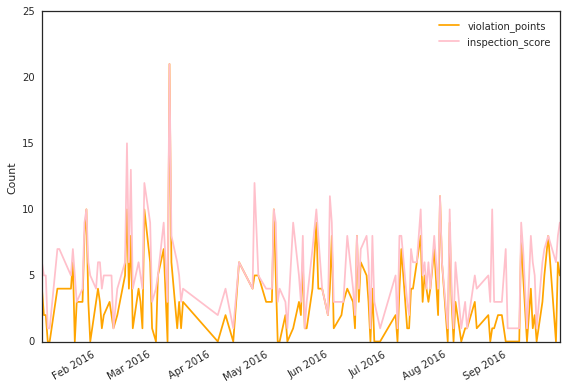

In [283]:
df.groupby('inspection_date')[['violation_points', 'inspection_score']].count().plot(color=['orange', 'pink'])
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()

Nothing too alarming here.. violations track with inspections

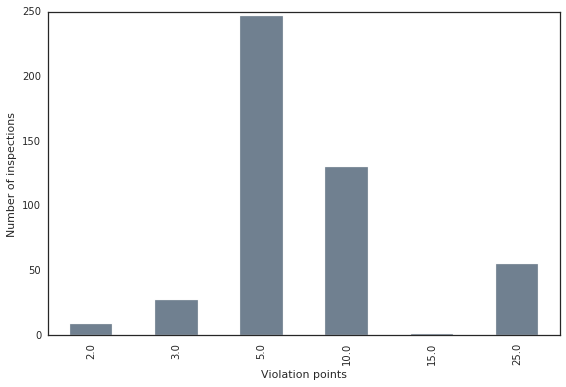

In [247]:
df.groupby('violation_points')['inspection_score'].count().plot(kind='bar', color='slategray')
plt.xlabel('Violation points')
plt.ylabel('Number of inspections')
plt.tight_layout()

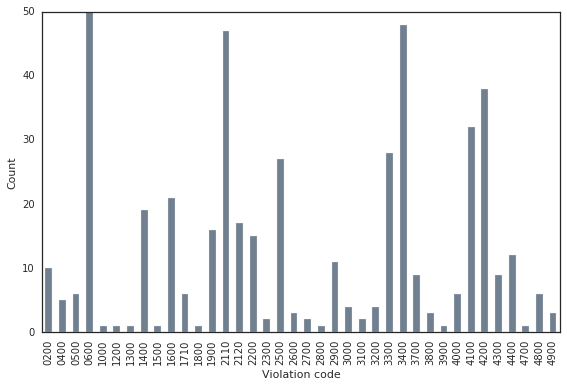

In [245]:
df.groupby('violation_code')['violation_code'].count().plot(kind="bar", color='slategray')
plt.xlabel('Violation code')
plt.ylabel('Count')
plt.tight_layout()